# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://ramp.r0h.eu/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

To do :
- mean encoding 
- regrouper variables catégoriques
- ajouter nouvelles données : distance aéroports (trouver fichier avec données)
- faire analyses descriptives

In [1]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## Fetch the data and load it in pandas

First we load `problem.py` that parameterizes the challenge. It contains some objects taken off the shelf from `ramp-workflow` (e.g., `Predictions` type, scores, and data reader). 

In [2]:
problem = imp.load_source('', 'problem.py')

`get_train_data` loads the training data and returns an `pandas` object (input) and a `np.array` object (output).

In [3]:
X_df, y_array = problem.get_train_data()
# the y array contains the log-like number of passengers on each flight 

In [4]:
print(min(X_df['DateOfDeparture']))
print(max(X_df['DateOfDeparture']))

2011-09-01
2013-03-05


In [5]:
X_df['log_PAX'] = y_array
cols = X_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
X_df = X_df[cols]
X_df.head()

,log_PAX,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,12.331296,2012-06-19,ORD,DFW,12.875000,9.812647
1,10.775182,2012-09-10,LAS,DEN,14.285714,9.466734
2,11.083177,2012-10-05,DEN,LAX,10.863636,9.035883
3,11.169268,2011-10-09,ATL,ORD,11.480000,7.990202
4,11.269364,2012-02-21,DEN,SFO,11.450000,9.517159


In [8]:
data = pd.read_csv('submissions/starting_kit/external_data.csv', sep=';')

In [9]:
X_encoded = X_df
external_data = data[['DateOfDeparture', 'Departure','Arrival', 'Mean TemperatureC', 'Distance',
                      'MeanDew PointC', 'Mean Humidity', 'Min VisibilitykM', 'Mean Sea Level PressurehPa',
                      'Max Wind SpeedKm/h', 'Precipitationmm', 'CloudCover',
                      'Events','dep_encod','ar_encod','Number_hab','Revenue']]
X_encoded = pd.merge(
            X_encoded, external_data, how='left',
            left_on=['DateOfDeparture', 'Arrival','Departure'],
            right_on=['DateOfDeparture', 'Arrival','Departure'],
            sort=False)
X_encoded.head()

,log_PAX,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd,Mean TemperatureC,Distance,MeanDew PointC,Mean Humidity,Min VisibilitykM,Mean Sea Level PressurehPa,Max Wind SpeedKm/h,Precipitationmm,CloudCover,Events,dep_encod,ar_encod,Number_hab,Revenue
0,12.331296,2012-06-19,ORD,DFW,12.875000,9.812647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.775182,2012-09-10,LAS,DEN,14.285714,9.466734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11.083177,2012-10-05,DEN,LAX,10.863636,9.035883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.169268,2011-10-09,ATL,ORD,11.480000,7.990202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.269364,2012-02-21,DEN,SFO,11.450000,9.517159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
X_encoded.drop(['std_wtd'], axis=1, inplace=True)

In [9]:
from sklearn.preprocessing import StandardScaler

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
X_encoded = X_encoded.drop('Departure', axis=1)
X_encoded = X_encoded.drop('Arrival', axis=1)

X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])

X_encoded['year']    = X_encoded['DateOfDeparture'].dt.year
X_encoded['month']   = X_encoded['DateOfDeparture'].dt.month
X_encoded['day']     = X_encoded['DateOfDeparture'].dt.day
X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
X_encoded['week']    = X_encoded['DateOfDeparture'].dt.week
X_encoded['n_days']  = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))




In [10]:
X_encoded[['day', 'log_PAX']].groupby(['day']).mean().sort_values(by='log_PAX', ascending=False)

,log_PAX
day,
13,11.212965
20,11.180188
16,11.176825
6,11.168391
11,11.161598
10,11.157406
14,11.149900
9,11.122189
17,11.109887


In [11]:
X_encoded[['year', 'log_PAX']].groupby(['year']).mean().sort_values(by='log_PAX', ascending=False)

,log_PAX
year,
2011,11.061834
2012,11.027577
2013,10.704285


In [12]:
X_encoded[['month', 'log_PAX']].groupby(['month']).mean().sort_values(by='log_PAX', ascending=False)

,log_PAX
month,
5,11.265602
6,11.236278
10,11.235431
9,11.170182
4,11.088636
8,11.062058
7,10.971289
11,10.960088
3,10.922401


In [13]:
X_encoded[['week', 'log_PAX']].groupby(['week']).mean().sort_values(by='log_PAX', ascending=False)

,log_PAX
week,
20,11.446715
38,11.396430
42,11.369646
23,11.341218
18,11.321315
41,11.320165
37,11.298643
43,11.298235
25,11.267389


In [14]:
X_encoded[['weekday', 'log_PAX']].groupby(['weekday']).mean().sort_values(by='log_PAX', ascending=False)

,log_PAX
weekday,
3,11.373103
0,11.298805
2,11.229835
4,11.228691
1,11.073679
6,10.826075
5,9.950706


In [15]:
X_encoded.drop(['year', 'month', 'day', 'weekday', 'week', 'n_days','DateOfDeparture'], axis=1, inplace=True)

In [16]:
X_encoded['Events'].fillna(0, inplace=True)
X_encoded['Events'] = X_encoded['Events'].replace(['Rain','Fog'], 1)
X_encoded['Events'] = X_encoded['Events'].replace(['Rain-Thunderstorm','Fog-Rain-Thunderstorm', 
                                                         'Rain-Snow','Snow','Fog-Rain','Thunderstorm','Fog-Snow', 
                                                         'Fog-Rain-Snow','Fog-Rain-Snow-Thunderstorm', 
                                                         'Rain-Snow-Thunderstorm','Rain-Hail-Thunderstorm', 
                                                         'Fog-Rain-Hail-Thunderstorm', 
                                                         'Rain-Thunderstorm-Tornado'], 2)

In [17]:
X_encoded['Precipitationmm'] = X_encoded['Precipitationmm'].replace('T', np.nan)
X_encoded['Precipitationmm'] = pd.to_numeric(X_encoded['Precipitationmm'])
X_encoded['Precipitationmm'] = X_encoded['Precipitationmm'].fillna(X_encoded['Precipitationmm'].mean())

In [18]:
X_encoded['Precipitationmm*CloudCover'] = X_encoded.Precipitationmm * X_encoded.CloudCover
X_encoded['Temperature*Humidity'] = X_encoded['Mean TemperatureC'] * X_encoded['Mean Humidity']

In [19]:
X_encoded['Weeks_to_dep_int'] = pd.qcut(X_encoded['WeeksToDeparture'], 4)
X_encoded.loc[X_encoded['WeeksToDeparture'] <= 9.524, 'WeeksToDeparture'] = 0
X_encoded.loc[(X_encoded['WeeksToDeparture'] > 9.524) & (X_encoded['WeeksToDeparture'] <= 11.3), 'WeeksToDeparture'] = 1
X_encoded.loc[(X_encoded['WeeksToDeparture'] > 11.3) & (X_encoded['WeeksToDeparture'] <= 13.24), 'WeeksToDeparture'] = 2
X_encoded.loc[ X_encoded['WeeksToDeparture'] > 13.24, 'WeeksToDeparture'] = 3
X_encoded['WeeksToDeparture'] = X_encoded['WeeksToDeparture'].astype(int)
X_encoded.drop(['Weeks_to_dep_int'], axis=1, inplace=True)

In [20]:
X_encoded.loc[:, 'Precipitationmm*CloudCover' : 'Temperature*Humidity'] = StandardScaler().fit_transform(
                                                            X_encoded.loc[:, 'Precipitationmm*CloudCover' : 'Temperature*Humidity'])

X_encoded.loc[:, 'Distance' : 'Max Wind SpeedKm/h'] = StandardScaler().fit_transform(
                                                            X_encoded.loc[:, 'Distance' : 'Max Wind SpeedKm/h'])

X_encoded.loc[:, 'dep_encod' : 'Revenue'] = StandardScaler().fit_transform(
                                                            X_encoded.loc[:, 'dep_encod' : 'Revenue'])

In [21]:
X_encoded.drop(['Mean TemperatureC','Mean Humidity','Precipitationmm','CloudCover'], axis=1, inplace=True)
X_encoded.drop(['MeanDew PointC', 'Mean Sea Level PressurehPa'], axis=1, inplace=True)
X_encoded.drop(['ar_encod'], axis=1, inplace=True)

In [22]:
y = X_encoded['log_PAX']
X_encoded.drop(['log_PAX'], axis=1, inplace=True)

In [23]:
X_encoded.head()

,WeeksToDeparture,Distance,Min VisibilitykM,Max Wind SpeedKm/h,Events,dep_encod,Number_hab,Revenue,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52,Precipitationmm*CloudCover,Temperature*Humidity
0,2,-0.394712,0.784753,1.593843,0,1.003612,-0.297994,-0.964522,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.309833,1.547196
1,3,-0.655678,0.784753,0.372957,0,-0.882932,-0.565232,-0.045009,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.309833,-0.855670
2,1,-0.306797,-0.611095,-0.660101,1,-1.178860,0.851261,0.712766,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.309833,0.955021
3,2,-0.686217,0.784753,-0.754015,0,0.004853,0.349556,-0.043487,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.309833,0.367726
4,2,-0.152253,-1.483500,-0.660101,0,-1.178860,-0.480338,0.712766,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.309833,0.117190


In [24]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X_encoded,label=y)

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, y, test_size=0.2)

In [ ]:
#Gridsearch
import xgboost as xgb
xgb1 = xgb.XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.2], 
              'max_depth': [7],
              'min_child_weight': [4],
              'subsample': [0.95],
              'colsample_bytree': [0.55],
              'n_estimators': [100,300,500,1000],
              'reg_lambda':[0.001],
              'gamma':[0]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train, Y_train)

print(xgb_grid.best_params_)

In [26]:
parameters = {'nthread':4,
              'objective':'reg:squarederror',
              'learning_rate': .3, 
              'max_depth': 7,
              'min_child_weight': 4,
              'subsample': 0.95,
              'colsample_bytree': 0.55,
              'n_estimators': 1000,
              'reg_lambda':0.001,
              'gamma':0}

cv_results = xgb.cv(dtrain=data_dmatrix, params=parameters, nfold=3,
                    num_boost_round=300,early_stopping_rounds=5,metrics="rmse", as_pandas=True, seed=123)

In [27]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7.395660,0.004722,7.396042,0.014637
1,5.198914,0.003730,5.200932,0.015870
2,3.666099,0.001876,3.671029,0.018266
3,2.599581,0.005853,2.611322,0.020896
4,1.862894,0.007510,1.879801,0.020254


In [28]:
print((cv_results["train-rmse-mean"]).tail(1))
print((cv_results["test-rmse-mean"]).tail(1))

97    0.168671
Name: train-rmse-mean, dtype: float64
97    0.403289
Name: test-rmse-mean, dtype: float64


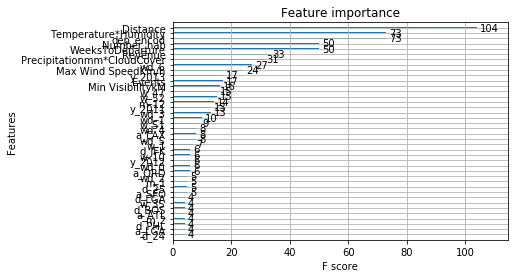

In [29]:
xg_reg = xgb.train(params=parameters, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg, max_num_features=40)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [31]:
import lightgbm as lgb 

//anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
from lightgbm import LGBMRegressor
lightgbm = LGBMRegressor(task= 'train',
          boosting_type= 'gbdt',
          objective= 'regression',
          metric= {'l2','auc'},
          num_leaves= 300,
          learning_rate= 0.32,
          feature_fraction= 0.9,
          bagging_fraction= .9,
          bagging_freq= 70,
          verbose= 100)

In [ ]:
cv_results = lgb.cv(dtrain=data_dmatrix, params=parameters, nfold=3,
                    num_boost_round=300,early_stopping_rounds=5,metrics="rmse", as_pandas=True, seed=123)